In [1]:
%matplotlib widget
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import NA_N9916A
import time
from scipy.optimize import curve_fit


import sys 
sys.path.insert(1, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Exercises_data')
sys.path.insert(2, r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\PAandQubit\Actual_Work')
from FunFit import *
import Tuls as Ts

ip          = '192.168.40.10' 
vna = NA_N9916A.N9916A(ip)

N9916A:	Connection successful!


In [6]:
span = 10e6 
f_c = 7.5745576e9
bw = 1e3            # IF BANDWIDTH
pauuer = -15

    
ip          = '192.168.40.10'   
mode        = 'NA'              
s_par       = 'S21'       
hdf5_file   = '2024-04-18.hdf5'     

n_pts = 600


                            
###############################



vna.set_num_pts(n_pts)

dict_keys(['f', 'I', 'Q'])


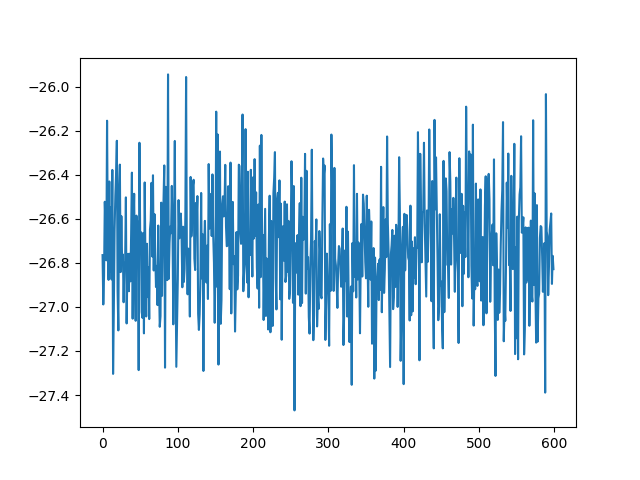

-26.73551971008728


In [7]:
# vna.set_freq_center(f_c)
# vna.set_freq_span(span)
# vna.set_scaling(auto = True)
# vna.set_power(-15)
# vna.set_freq_bandwidth(bw)
sweep = vna.get_data()
print(sweep.keys())
#Ts.save_dict_to_hdf5(sweep, 'Ris_piccola_left_lowpower.h5')

f, I, Q = sweep.values()
amp = 10*np.log10(I**2 + Q**2) # amplitude

plt.clf()
plt.plot(amp)
plt.show()

print(np.mean(amp))
# senza power combiner è -23.3012148 dBm
# con lui è -26.73551971008728

## Dati sottostanti:
Attenuazione in uscita dal VNA di 10dBm e amplificazione in entrata +16 dBm max

In [14]:
f_min = 7.572768071e9
f_max = 7.582768071e9
bw = 10e3            # IF BANDWIDTH

vna.num_avgs(5)
vna.set_freq_range(f_min, f_max)
vna.set_scaling(3, -30, 5)
powers = np.arange(-45, -10,0.5)
data = {}

for i,p in enumerate(powers):
    time.sleep(5)
    vna.set_power(p)
    data[f'Sweep_{i}'] = {'Power': p, 'Sweep': vna.get_data()}
    



In [68]:
dota = Ts.load_hdf5_to_dict('long_PUNCHOUT_att10dBm_rightpeak.h5')

sorted = []

for i in range(len(dota.keys())):
    sorted.append(f'Sweep_{i}')



power = []
ampls = []

for i in sorted:
    power.append(dota[i]['Power'])
    I = Ts.find_key(dota[i], 'I')
    Q = Ts.find_key(dota[i], 'Q')
    amp = 10*np.log10(I**2 + Q**2)
    #amp = amp/np.min(amp)
    ampls.append(amp)

ampls = np.array(ampls)[1:]
power = np.array(power)[1:]
f = Ts.find_key(subdota, 'f')

plt.figure(figsize=(10,6))
plt.pcolor(f, power, ampls)
plt.show()

import plotly.express as px

print(ampls.shape)
print(power.shape)
print(f.shape)

fig = px.imshow(ampls, aspect="auto", labels=dict(x = 'Frequency (GHz)', y = 'Power (dBm impostati sul VNA, ricordati di atten)', z = 'MSR'), x = f, y = power, origin = 'lower')

fig.update_layout(
    xaxis=dict(tickformat=".1e"), 
    width = 800,
    height = 500
    )

fig.update_traces(hoverongaps=False, hovertemplate='Frequency: %{x}<br>Amplitude: %{y}<br>MSR: %{z}')

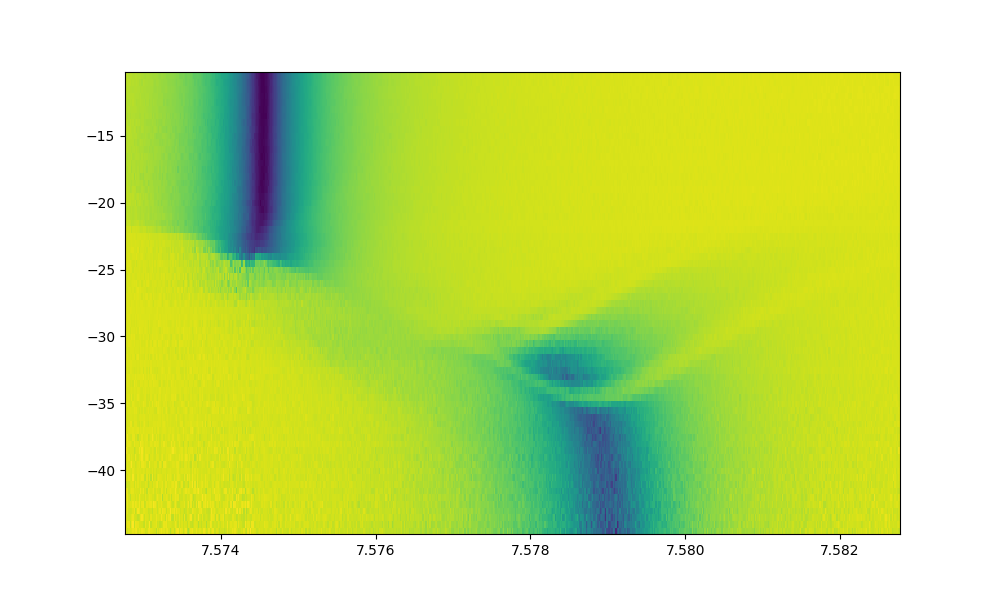

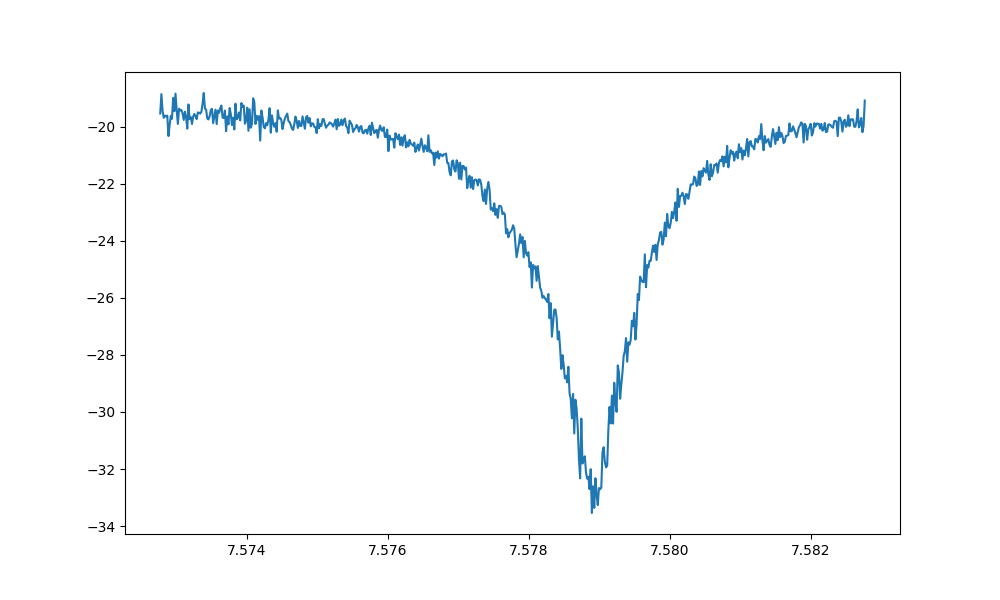

In [12]:
dota = Ts.load_hdf5_to_dict('long_PUNCHOUT_att10dBm_rightpeak.h5')
k = 13   # scegli sweep da visualizzare qui momentaneamente

sorted = []

for i in range(len(dota.keys())):
    sorted.append(f'Sweep_{i}')


fr = Ts.find_key(dota[f'Sweep_{k}'], 'f')
I = Ts.find_key(dota[f'Sweep_{k}'], 'I')
Q = Ts.find_key(dota[f'Sweep_{k}'], 'Q')
modulo = 10*np.log10(I**2 + Q**2)
plt.figure(figsize=(10,6))
plt.plot(fr, modulo)
plt.show()

In [ ]:
# # potenza inviata = -15 dmb
# saved_sweep = vna.r_hdf_data(hdf5_file, 'NA_S21', 11)
# # print(saved_sweep)
# I, a, Q, b, f = saved_sweep.values()

# f = f_c

# amp = 10*np.log10(I**2 + Q**2) # amplitude

# # plt.clf()
# # plt.plot(f, amp)
# # plt.show()


# a_l = a*0.4
# a_r = a*0.6
# mask = (f < 8.57203) & (f > 8.57178)
# y = (-amp[mask]).tolist()
# x = f[mask].tolist()

# x_c = x
# y_c = y

# D1_min = min(y)
# D1_max = max(y)
# idx_max = y.index(max(y))
# D1_peak = x[idx_max]

# half_height = (D1_max + D1_min)/2
# print(half_height)

# argMax = np.argmax(y)
# idx_L = np.argmin(np.abs(half_height - np.array(y[:argMax])))
# idx_R = np.argmin(np.abs(half_height - np.array(y[argMax:]))) + (idx_max + 1)

# # fig = plt.figure()
# # plt.plot(x, y)
# # plt.plot([x[idx_L],x[idx_R]], [y[idx_L],y[idx_R]], ls = 'none', marker = 'o')

# D1_gamma = x[idx_R] - x[idx_L]
# # plt.show()

# print('Minimum:', D1_min)
# print('Maximum:', D1_max)
# print('f peak:', D1_peak)
# print('Gamma:', D1_gamma)

# # Amplitude, x0, Gamma, Minimum
# pars = [-10, ]
# pars = [D1_max, D1_peak, D1_gamma, D1_min]

# pars_opt, err_cov = curve_fit(Lorentzian, x, y, pars)
# plt.figure()
# plt.plot(x_c, y_c, marker = '.', linewidth = 1)   
# plt.plot(x_c, Lorentzian(x_c, *pars_opt))